In [27]:
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import sympy
#pip install plotly
import plotly
import plotly.express as px
#pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import re

Краткое саммари по использованным технологиям:
1. Продвинутые возможности пандас в Анализе для ворочанья датафреймов
2. Selenium для скреппинга страниц
3. API в рамках домашних работ для сбора данных
4. Сложные визуализации в mathplotlib и не очень сложные в pyplot
5. Numpy и SymPy для подсчета вероятностей в Анализе
6. Streamlit и Heroku для размещения интерактивной части проекта в интернете, достаточно перейти по ссылке
7. Регулярные выражения для проверки корректности введеной пользователем информации

Теперь содержательно:

<img src="I_menia.jpg">

Очень люблю астрологию, гороскопчики и рыб. Поэтому решила проверить насколько это все правда. Для этого мы можем взять например топ-200 богатейших людей, посмотреть на их натальные карты (это астрологи рисуют положение планет в момент рождения, соединяют планеты, звезды и радуются) и посмотреть наличие закономерностей. Если они есть, астрология работает. А в конце будет возможность посмотреть вашу собственную натальную карту, и на основе полученных выводов вы сможете понять, насколько звезды вас любят в материальном плане.

*(В какой-то момент я начну все небесные тела для краткости называть планетами, не бейте)*

# Скучный сбор данных

Сначала нам нужно насобирать данные о богатых людях. Заходим на сайт Форбс: https://www.forbes.com/billionaires/. Там список людей не на самой странице, а на прокручиваемом окне, и каждые 200 человек нужно кликать на кнопку "Next 200" - нужен **Селениум**. Им собираем данные о богатых людях с запасом - наберем топ 600 (минут 5). Я прикреплю базу данных (нужно запустить ячейку перед Анализом, там отмечено), которую в итоге собрала, поэтому можно не запускать код с Селениумом, но как хотите)

То есть **дальше запускать клеточки не обязательно**:

In [2]:
from selenium import webdriver
from selenium.webdriver import Chrome
import time
driver = webdriver.Chrome(executable_path=r'сюда вбейте где лежит ваш chromedriver')

In [320]:
url = "https://www.forbes.com/billionaires/"
driver.get(url)

namess=[]
wealth=[]
time.sleep(3)
for k in range(3):

    time.sleep(3)
    richguys = driver.find_elements_by_css_selector(
      ".personName")
    networth = driver.find_elements_by_css_selector(
      ".netWorth")

    for i in range(1,len(richguys)):
        namess.append(richguys[i].text)
        wealth.append(networth[i].text)

    driver.find_element_by_css_selector(
      ".next-page").click()

#print(namess[-1]) - должен вывести WINIFRED JOHNSON-MARQUART

In [321]:
len(namess)#Должно быть 600

600

Теперь у нас есть имена и богатство этих людей. Но богатство записано в виде строк \$109B. Переведем их в числа. А также для прогнозов, нам нужна дата и место рождения. Это приятно вебскреппить с википедии. Для этого нужно имена типа JEFF BEZOS & FAMILY перевести в Jeff Bezos, а потом генерировать URL по типу: https://en.wikipedia.org/wiki/Jeff_Bezos. Несложно, поперли:

In [322]:
names=[]

for i in namess:
    if "FAMILY" in i:
        i=i.replace(" & FAMILY","")
    i=i.lower()
    i=i.title()
    names.append(i)
    
networth=[]

for i in wealth:
    i=i.replace("$","")
    i=i.replace(" B","")
    #print(i)
    networth.append(float(i))

Вот тут вебскреппим Википедию (это долго, но не дольше 10 минут):

In [323]:
def get_birth_info(name):
    a = "NaN"
    b = "NaN"
    bname=name.title()
    urlname = bname.replace(' ', '_')
    url = "https://en.wikipedia.org/wiki/"+urlname
    #print(url)
    r = requests.get(url)
    if r.ok:
        page = BeautifulSoup(r.text, 'lxml')
        #print(page)
        #print("\n") 
        h2 = page.find_all("tbody")
        #print(h2[0])
        if h2 !=[]:
            rows = h2[0].find_all("span", class_="bday")
            if rows!=[]:    
                a = rows[0].string
        h1 = page.find_all("div", class_="birthplace")
        if h1!=[]:
            b=h1[0].text
    return([a,b])

Собираем информацию про каждого:

In [324]:
birthday=[]
birthplace=[]
for i in names:
    c = get_birth_info(i)
    birthday.append(c[0])
    birthplace.append(c[1])

Теперь из даты вида 01-01-1999 достаем по отдельности день, месяц и год:

In [325]:
day=[]
month=[]
year=[]
for i in birthday:
    a=i.split('-')
    if len(a)!=3:
        day.append('NaN')
        month.append('NaN')
        year.append('NaN')
    else:
        day.append(int(a[2]))
        month.append(int(a[1]))
        year.append(int(a[0]))

Теперь из города рождения нужно получить долготу и широту через **API** (тоже минут 10): 

In [326]:
entrypoint = "https://nominatim.openstreetmap.org/search"
def lat_lon(place):
    r = requests.get(entrypoint, {'q': place,'format': 'json'})
    a = r.json()
    b = 'NaN'
    c = 'NaN'
    if a!=[]:
        b = float(a[0]['lat'])
        c = float(a[0]['lon'])
    return([b,c])

In [327]:
latitude = []
longitude = []
for i in birthplace:
    c=lat_lon(i)
    latitude.append(c[0])
    longitude.append(c[1])

In [328]:
d = {"birthday":pd.Series(birthday),"name":pd.Series(names),"wealth":pd.Series(networth),
   "day":pd.Series(day),"month":pd.Series(month),"year":pd.Series(year),
     "latitude":pd.Series(latitude),"longitude":pd.Series(longitude)}
df = pd.DataFrame(d)
df

,birthday,name,wealth,day,month,year,latitude,longitude
0,1964-01-12,Jeff Bezos,113.0,12,1,1964,35.0841,-106.651
1,1955-10-28,Bill Gates,98.0,28,10,1955,47.6604,-122.291
2,1949-03-05,Bernard Arnault,76.0,5,3,1949,50.6916,3.17417
3,1930-08-30,Warren Buffett,67.5,30,8,1930,41.3043,-95.8935
4,1944-08-17,Larry Ellison,59.0,17,8,1944,40.7491,-73.968
...,...,...,...,...,...,...,...,...
595,NaN,Dan Friedkin,3.3,NaN,NaN,NaN,32.7174,-117.163
596,NaN,H. Fisk Johnson,3.3,NaN,NaN,NaN,42.7261,-87.7825
597,NaN,S. Curtis Johnson,3.3,NaN,NaN,NaN,46.3145,11.048
598,NaN,Helen Johnson-Leipold,3.3,NaN,NaN,NaN,46.3145,11.048


In [329]:
dx = df[lambda x: x['day'] !='NaN']
dx = dx[lambda x: x['day'] !='Nan']
dx = dx[lambda x: x['latitude'] !='NaN']
dx = dx[lambda x: x['latitude'] !='Nan']
dx

,birthday,name,wealth,day,month,year,latitude,longitude
0,1964-01-12,Jeff Bezos,113.0,12,1,1964,35.0841,-106.651
1,1955-10-28,Bill Gates,98.0,28,10,1955,47.6604,-122.291
2,1949-03-05,Bernard Arnault,76.0,5,3,1949,50.6916,3.17417
3,1930-08-30,Warren Buffett,67.5,30,8,1930,41.3043,-95.8935
4,1944-08-17,Larry Ellison,59.0,17,8,1944,40.7491,-73.968
...,...,...,...,...,...,...,...,...
583,1960-03-03,"Enrique Razon, Jr.",3.4,3,3,1960,46.3145,11.048
586,1939-01-21,Lynn Schusterman,3.4,21,1,1939,39.1001,-94.5781
590,1948-03-09,Mohed Altrad,3.3,9,3,1948,35.9497,39.0089
591,1957-09-09,Shari Arison,3.3,9,9,1957,40.7491,-73.968


Вот мы выкинули все строки с NaN. Вышло 220 человек - нормальная выборка. Используем специальную страшную **API** для астрологии:

In [330]:
### FROM: https://github.com/astrologyapi/astro-api-python-client/blob/master/sdk.py
class VRClient:
    baseURL = "http://api.vedicrishiastro.com/v1/"

    def __init__(self, uid, key):
        self.userID = uid
        self.apiKey = key

    def getUrl(cls):
        return cls.baseURL

    def getResponse(self, resource, data):
        url = self.getUrl() + resource
        resp = requests.post(url, data=data, auth=(self.userID, self.apiKey))
        return resp
    
    def packageHoroData(self, date, month, year, hour, minute, latitude, longitude, timezone):
        return {'day': date,
            'month': month,
            'year': year,
            'hour': hour,
            'min': minute,
            'lat': latitude,
            'lon': longitude,
            'tzone': timezone}

    def call(self, resource, date, month, year, hour, minute, latitude, longitude, timezone):
        data = self.packageHoroData(date, month, year, hour, minute, latitude, longitude, timezone)
        return self.getResponse(resource, data)
### END FROM

In [331]:
def planets(day1,month1,year1,latitude1,longitude1): 
    data = {'date': day1,
        'month': month1,
        'year': year1,
        'hour': 12,
        'minute': 0,
        'latitude': latitude1,
        'longitude': longitude1,
        'timezone': 0}
    ### FROM: https://github.com/astrologyapi/astro-api-python-client/blob/master/test.py
    userID = "613209"
    apiKey = "23bf5d2cd5f1b79e22c5b7acde1b2b3b"

    resource = "planets/tropical"

    client = VRClient(userID, apiKey)

    responseData = client.call(resource, data['date'], data['month'], data['year'], 
            data['hour'], data['minute'], data['latitude'], data['longitude'], data['timezone'])

    loaded_json = json.loads(responseData.text)

    #print(loaded_json)
    ### END FROM
    return(loaded_json)

In [332]:
list_planets=['Sun','Moon','Mars','Mercury','Jupiter','Venus','Saturn','Uranus','Neptune','Pluto','Acendant']

Теперь для людей без NaN посмотрим натальные карты (еще минут 10), и я наконец выгружу данные в табличку, которую прикреплю, так что ее можно будет просто прочитать.

In [333]:
Nathal_carts = []
for i in dx.index:
    s=planets(day[i],month[i],year[i],latitude[i],longitude[i])
    #print(day[i],month[i],year[i],latitude[i],longitude[i])
    Nathal_carts.append(s)

In [334]:
#Тут собираю знаки зодиака
signs=[]
for i in Nathal_carts:
    signs.append(i[0]['sign'])

In [335]:
# Тут собираю положение планет, а пото табличку в пандас, 
# потому что работать с тем срезом, который у нас есть, неудобно, и он нам больше не пригодится.
Sun_h=[]
Moon_h=[]
Mars_h=[]
Mercury_h=[]
Jupiter_h=[]
Venus_h=[]
Saturn_h=[]
Uranus_h=[]
Neptune_h=[]
Pluto_h=[]

for i in Nathal_carts:
    Sun_h.append(i[0]['house'])
    Moon_h.append(i[1]['house'])
    Mars_h.append(i[2]['house'])
    Mercury_h.append(i[3]['house'])
    Jupiter_h.append(i[4]['house'])
    Venus_h.append(i[5]['house'])
    Saturn_h.append(i[6]['house'])
    Uranus_h.append(i[7]['house'])
    Neptune_h.append(i[8]['house'])
    Pluto_h.append(i[9]['house'])
    
YearP=[]
WealthP=[]
NameP=[]
for i in dx.index:
    YearP.append(year[i])
    WealthP.append(networth[i])
    NameP.append(names[i])
    
d={'Sun':pd.Series(Sun_h),'Moon':pd.Series(Moon_h),'Mars':pd.Series(Mars_h),
  'Mercury':pd.Series(Mercury_h),"Jupiter":pd.Series(Jupiter_h),
  'Venus':pd.Series(Venus_h),'Saturn':pd.Series(Saturn_h),'Uranus':pd.Series(Uranus_h),
  'Neptune':pd.Series(Neptune_h),'Pluto':pd.Series(Pluto_h)
   ,"Year":pd.Series(YearP), "Wealth":pd.Series(WealthP), "Name":pd.Series(NameP),"Sign":pd.Series(signs)
  }
db=pd.DataFrame(d)
db.to_csv('Astrology_DataBase_generated')
db

,Sun,Moon,Mars,Mercury,Jupiter,Venus,Saturn,Uranus,Neptune,Pluto,Year,Wealth,Name,Sign
0,1,1,2,1,4,2,2,9,11,9,1964,113.0,Jeff Bezos,Capricorn
1,2,6,1,1,11,2,2,10,2,11,1955,98.0,Bill Gates,Scorpio
2,9,11,10,8,7,9,3,12,4,2,1949,76.0,Bernard Arnault,Pisces
3,12,3,10,2,11,2,4,8,12,11,1930,67.5,Warren Buffett,Virgo
4,12,11,1,1,12,12,10,9,1,11,1944,59.0,Larry Ellison,Leo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,9,11,8,10,6,8,6,2,5,3,1960,3.4,"Enrique Razon, Jr.",Pisces
216,1,1,11,1,2,12,3,4,8,7,1939,3.4,Lynn Schusterman,Aquarius
217,8,8,1,7,5,10,1,11,3,1,1948,3.3,Mohed Altrad,Pisces
218,12,6,12,12,1,1,3,11,2,11,1957,3.3,Shari Arison,Virgo


## База данных
Тут нужно **запустить ячейку** и выгрузить наконец ту таблицу, которую я уже собрала (либо которую вы собрали, если вы прошли через всю эту боль - будет открыта она):

In [4]:
import os.path 
if os.path.exists('Astrology_DataBase_generated'):
    Frame=pd.read_csv('Astrology_DataBase_generated')
else:
    Frame=pd.read_csv('I_menia')

del Frame['Unnamed: 0']#там появился лишний столбец с индексами
Frame
list_planets=['Sun','Moon','Mars','Mercury','Jupiter','Venus','Saturn','Uranus','Neptune','Pluto','Acendant']

# Анализ полученных данных

Теперь запускаем все ячейки, чтобы видеть красивые картиночки. Первая идея проверить знаки зодиака:

In [8]:
px.bar(data_frame=Frame, x='Sign', color='Wealth',
       category_orders={'Sign':['Aries','Taurus','Gemini','Cancer','Leo','Virgo','Libra','Scorpio','Sagittarius','Capricorn','Aquarius','Pisces']},
      color_continuous_scale=px.colors.sequential.Plasma) 
# Если на вас сейчас что-то ругается, проверьте что у вас установлен Plotly и Mathplotlib в верхней ячейке этого проекта
# Plotly должен быть версии 4.8.1

На самом деле какого-то большого перекоса не происходит. Поэтому обратимся к Западной астрологии, у которой есть не только знаки, но и дома. **Краткий экскурс в псевдонауку**. В день вашего рождения планеты, звезды и спутники находятся в каком-то градусном положении на небе. Мы представляем небо как кружочек и делим его на 12 частей - их называют дома. В каждом доме есть какое-то большое созвездие которые является повелителем этого дома. Ну и как бы, логично, если у кого-то Солнце в первом доме - доме Овна - то, наверно, человек звездануто упрямый. Так теперь и будем пытаться уловить, что же может повлиять на наш достаток. Соответственно, в таблице напротив каждого небесного тела - дом, в котором находилась это тело, в момент рождения конкретного человека.

Для начала давайте вообще проверим, может быть нам важно в какой дом наберется больше всего планет? Ну то есть, логично, что если у 199 из 219 людей в 8 доме будут по 8 из 10 небесных тел, то есть догадки, что это что-то да значит. Давайте проверим. Для начала приведем табличку в приятный вид - силами **сложных функций в pandas** расконтачим ее чтобы каждое попадание тела в дом было строкой и потом их можно было удобней подсчитывать:

In [9]:
a = Frame.unstack()
s = a.to_frame()
s = s.reset_index()
s = s.rename(columns={"level_0": "planet", "level_1": "person", 0:"house"})
match={1:'01 house, Aries', 2:'02 house, Taurus', 3:'03 house, Gemini',4:'04 house, Cancer',5:'05 house, Leo',
6:'06 house, Virgo',7:'07 house, Libra', 8:'08 house, Scorpio',9:'09 house, Sagittarius',10:'10 house, Capricorn',
       11:'11 house, Aquarius',12:'12 house, Pisces'}
s["House"] = s["house"].map(match)
s = s.loc[lambda x: x['planet'] !='Name']
s = s.loc[lambda x: x['planet'] !='Wealth']
s = s.loc[lambda x: x['planet'] !='Year']
s = s.loc[lambda x: x['planet'] !='Sign']
s

,planet,person,house,House
0,Sun,0,1,"01 house, Aries"
1,Sun,1,2,"02 house, Taurus"
2,Sun,2,9,"09 house, Sagittarius"
3,Sun,3,12,"12 house, Pisces"
4,Sun,4,12,"12 house, Pisces"
...,...,...,...,...
2195,Pluto,215,3,"03 house, Gemini"
2196,Pluto,216,7,"07 house, Libra"
2197,Pluto,217,1,"01 house, Aries"
2198,Pluto,218,11,"11 house, Aquarius"


Теперь группируем эту радость по домам и планетам, чтобы знать, сколько раз среди 220 богатейших людей каждое тело попало в каждый дом:

In [10]:
s_counts = s.groupby(['planet', 'House']).size().reset_index(name='counts')
s_counts

,planet,House,counts
0,Jupiter,"01 house, Aries",11
1,Jupiter,"02 house, Taurus",10
2,Jupiter,"03 house, Gemini",22
3,Jupiter,"04 house, Cancer",18
4,Jupiter,"05 house, Leo",21
...,...,...,...
111,Venus,"08 house, Scorpio",30
112,Venus,"09 house, Sagittarius",27
113,Venus,"10 house, Capricorn",29
114,Venus,"11 house, Aquarius",27


И сведем это все в человеческую табличку где напротив каждого дома и планеты - количество их совпадений:

In [11]:
n = s_counts.pivot_table('counts', index='House', columns='planet')
n = n.fillna(0)
n

planet,Jupiter,Mars,Mercury,Moon,Neptune,Pluto,Saturn,Sun,Uranus,Venus
House,,,,,,,,,,
"01 house, Aries",11.0,24.0,31.0,19.0,23.0,17.0,18.0,30.0,7.0,22.0
"02 house, Taurus",10.0,12.0,7.0,16.0,19.0,17.0,23.0,6.0,12.0,20.0
"03 house, Gemini",22.0,20.0,0.0,17.0,20.0,6.0,26.0,0.0,19.0,3.0
"04 house, Cancer",18.0,12.0,0.0,20.0,17.0,16.0,20.0,0.0,16.0,4.0
"05 house, Leo",21.0,9.0,16.0,19.0,10.0,17.0,11.0,12.0,19.0,11.0
"06 house, Virgo",24.0,16.0,13.0,25.0,20.0,15.0,20.0,18.0,10.0,13.0
"07 house, Libra",21.0,13.0,7.0,20.0,18.0,21.0,18.0,6.0,24.0,14.0
"08 house, Scorpio",17.0,20.0,16.0,22.0,20.0,20.0,21.0,6.0,32.0,30.0
"09 house, Sagittarius",20.0,27.0,48.0,18.0,14.0,27.0,12.0,91.0,19.0,27.0


In [26]:
px.imshow(n,labels=dict(x="Planets", y="Houses",color_discrete_sequence= px.colors.sequential.Plasma,
                        color="Amount of people"),
                  x=list(n),y=n.index)

Сразу видно что Меркурий с Солнцем и 9 дом очень интересные. Пока не очень очевидно, так что построим еще две диаграммы, где интересно потыкаться - на одной будет хорошо видна суммарная зависимость, а в другой насколько одни планеты - овощи и роли не играют, а какие делают что-то странное. Таблица уже есть, нужно только ее обратно unstack, потому что у нас появились 0, которых раньше не было в таблице (когда мы приводили ее в последний раз на пересечении, например, 4 дома и Меркурия был NaN, который мы заменили на 0). Поэтому нам нужно снова привести ее в вид, где напротив каждой планеты будет дом, куда она попала, и построить график:

In [8]:
forkrug = n.unstack()
forkrug = forkrug.to_frame()
forkrug = forkrug.reset_index().sort_values(by=['House'])
forkrug = forkrug.rename(columns={0:"counts"})
forkrug# смотрите, длина стала больше на 4 пустых клетки, они нужны в графике с "розами ветров"

,planet,House,counts
0,Jupiter,"01 house, Aries",11.0
36,Moon,"01 house, Aries",19.0
12,Mars,"01 house, Aries",24.0
48,Neptune,"01 house, Aries",23.0
108,Venus,"01 house, Aries",22.0
...,...,...,...
35,Mercury,"12 house, Pisces",36.0
23,Mars,"12 house, Pisces",18.0
11,Jupiter,"12 house, Pisces",20.0
107,Uranus,"12 house, Pisces",19.0


In [9]:
fig = px.bar_polar(forkrug, r="counts", theta="House",
                   color="planet", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma)
fig.show()

Напротив каждого дома - сколько планет каждого типа среди 220 людей в него вошли. Видно, что 9 дом действительно сильно вырывается вперед. Но также видно что это все Солнце. Справа в легенде можно его выключить, и заметить, что среди остальных планет такого разрыва суммарно нет, но вообще одна половина небосвода доминирует над другой. Теперь давайте посмотрим, есть ли еще кроме Солнца какие-то странные случаи:

In [10]:
fig = px.line_polar(forkrug, r="counts", theta="House", color="planet", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma,
                    template="plotly_dark",)
fig.show()

Тут опять полезно выключить Солнце, потому что оно из-за масштаба сжимает остальные планеты. Теперь Видно что Меркурий довольно сильно штырит, в основном он находится в 1, 9, 10 и 12 домах. (Если выключить все кроме Солнца и Меркурия, то кажется будто они должны попадать в 1, 5, 6, 9, 10 и 12 дома) Плюс Венера и Марс немного чаще встречаются в половине небосвода у 8-11-2 дома. Остальные просто немного кривые, но все же круги.

Новая идея: а что, если важна корреляция между планетами? То есть например, Марс и Венера должны находится в соседних домах для равновесия мужского и женского. Звучит правдоподобно, проверяем.

Здесь каждый маленький график это координаты в домах для каждой пары планет. Тут каждый человек очень прозрачный, тогда, если точка жирная, то это много людей. Доход людей помог бы нам определить самые богатые места, но такого не случилось. Смотрим:

In [11]:
px.scatter_matrix(data_frame=Frame, dimensions=list_planets[:-1],opacity=0.2, height=1000, color='Wealth')

Видно что корреляция есть только внутри двух троек: Солнце, Венера и Меркурий и Уран, Нептун и Плутон. Но вторая тройка объясняется тем, что эти планеты очень далеко от нас и очень медленно меняют свой граду относительно друг друга. Это можно отчетливо заметить на таком графике:

In [12]:
px.scatter(x='Pluto', y='Neptune', size="Wealth", data_frame=Frame, color="Year",template="plotly_dark", opacity=0.5, 
           width=500,height=500,size_max=30,#marginal_x='violin', marginal_y='violin'
          )

Тут опять же - каждый человек прозрачен, много людей - более яркая точка. А чем больше круг - тем богаче человек. Но самый сок в цвете. Так как дома располагаются по кругу, то мы на самом деле могли бы замкнуть этот график. Тогда у нас получится как бы кольцо. И мы движемся по нему, вроде как, снизу-слева вверх-вправо. Мы переходим от холодного розового к теплому оранжевому, а синяя точка какого-то богача 1837 года рождения, как бы намекает что мы правы и это просто естественное движение этих планет. Аналогичное верно для других пар планет из этой тройки (там градиент еще больше бросается в глаза):

In [13]:
fig1=px.scatter(x='Pluto', y='Uranus', size="Wealth", data_frame=Frame, color="Year",template="plotly_dark", opacity=0.3, 
           width=600,height=600,size_max=30,marginal_x='violin', marginal_y='violin')
fig2=px.scatter(x='Neptune', y='Uranus', size="Wealth", data_frame=Frame, color="Year",template="plotly_dark", opacity=0.3, 
           width=600,height=600,size_max=30,marginal_x='violin', marginal_y='violin')
fig1.show()
fig2.show()

Теперь можно просто вблизи полюбоваться на тройку Солнце, Меркурий, Венера:

In [14]:
px.scatter_3d(x='Mercury', y='Venus',z='Sun', size="Wealth", data_frame=Frame, color="Year",template="plotly_dark", 
              opacity=0.7, width=800,height=650,size_max=30)

Может показаться, что, ура, смотрите, магия. У успешных людей эти три планеты идут вместе, однако это тоже естественно. Они почти всегда находятся примерно рядом (то, что некотороые точки находятся в уголочках куба - проблема того, что мы не можем сомкнуть этот отрезок в кольцо по трем измерениям). И получается что тут мы пока успеха не добились.

Но смотрите, получается что Солнце, Меркурий, Венера и Плутон, Нептун, Юпитер обычно оказываются примерно в одном доме. Если же читать астрологические тексты, то там сказано, что круто, если у человека много разных домов. Каждый дом - это ваша суперспособность. Больше домов собрали - больше сил в этом жестоком мире. Так что давайте посмотрим, с одной стороны - сколько уникальных домов собрали богатые люди. А с другой - сколько должны были набрать, используя упрощение, что попадение каждой планеты в каждый дом это $\frac{1}{12}$ и события независимы.

Для подсчета предсказания мы будем использовать **sympy** и **numpy**. Пусть мы хотим, чтобы планеты попали в i из 12 домов. Считаем сколько вариантов этого события. С одной стороны нужно из 12 домов выбрать i, с другой стороны, расположить 10 планет в i домов, при том, что в каждом доме хотя бы по 1 планете. Считая планеты одинаковыми и используя метод перегородок, получим:
$$C_{12}^{i}\cdot \frac{((10-i)+(i-1))!}{(10-i)!(i-1)!}=C_{12}^{i}\cdot C_{9}^{10-i}$$
Отлично, и i может принимать значение от 1 до 10. Считаем каждый случай, потом общее количество вариантов через их сумму. Деля одно на другое - находим вероятность выпадение такого количества уникальных домов и умножаем на 220 человек, которые у нас есть. Получаем предсказание:

In [15]:
predicted=np.array([])
sump=0
for i in range(1,11):
    a=sympy.binomial(12,i)
    b=sympy.binomial(9,10-1)
    predicted=np.append(predicted,float(a*b))
    sump=sump+a*b
predicted=predicted/sump*220
predicted=predicted.tolist()#теперь у нас есть список с предсказанными данными

#используем вот эту таблицу, которую мы сделали в самом начале, для сбора реальных данных по количеству уникальных данных
s

,planet,person,house,House
0,Sun,0,1,"01 house, Aries"
1,Sun,1,2,"02 house, Taurus"
2,Sun,2,9,"09 house, Sagittarius"
3,Sun,3,12,"12 house, Pisces"
4,Sun,4,12,"12 house, Pisces"
...,...,...,...,...
2195,Pluto,215,3,"03 house, Gemini"
2196,Pluto,216,7,"07 house, Libra"
2197,Pluto,217,1,"01 house, Aries"
2198,Pluto,218,11,"11 house, Aquarius"


In [16]:
b=s.groupby('person')['house'].nunique()
d={'Unique':pd.Series(b),"Wealth":pd.Series(Frame['Wealth']), "Name":pd.Series(Frame['Name']),
   'Sun':pd.Series(Frame['Sun'])}
dc=pd.DataFrame(d)
mostrich=[]
veryrich=[]
rich=[]
for i in np.arange(1,11):
    b=dc.loc[lambda x: x['Unique'] ==i]
    z=len(b)
    x=len(b.loc[lambda x: x['Wealth'] >30])
    y=len(b.loc[lambda x: x['Wealth'] >10])
    mostrich.append(x)
    veryrich.append(y)
    rich.append(z)

Готовы рисовать. Так как я хотела сделать, не получилось осуществить модно в pyplote, поэтому будем писать **сложную визуализацию в mathplotlib**:

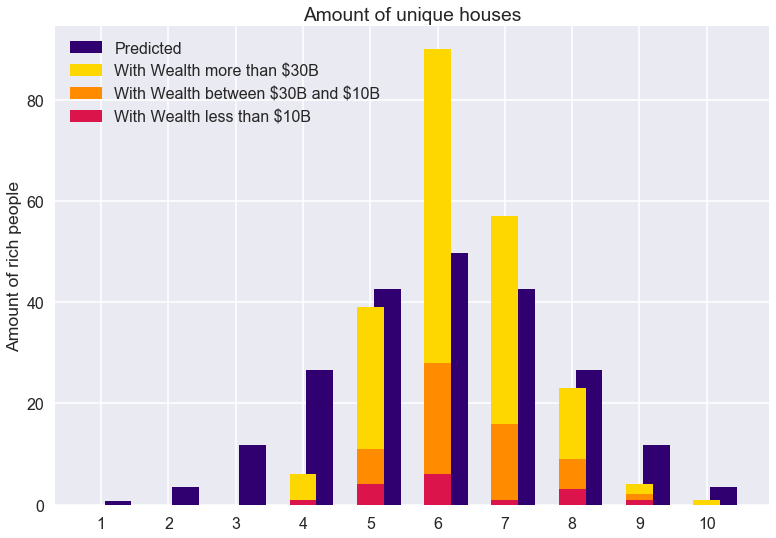

In [17]:
style.use('seaborn-poster')
style.use('seaborn-darkgrid')
N = 10
indexes = np.arange(N) + 0.15
fig, ax = plt.subplots()
width = 0.4
bars1 = ax.bar(indexes + 0.65, predicted, width, color='#300070') 
bars2 = ax.bar(indexes + width, rich, width, color='#FFD700') 
bars3 = ax.bar(indexes + width, veryrich, width, color='#FF8C00') 
bars4 = ax.bar(indexes + width, mostrich, width, color='#DC144C')
# Не получилось нарисовать в плотли то, что хочу, потому что там нельзя делать одновременно стакнутые и соседние столбцы.
# То есть проблема в том, что я не могу одновременно раскрасить какие-то столбцы и сделать еще стоящие рядом не раскрашенные
# Поэтому я просто рисую их друг на друге. Тут нарисован желтый столбец, на нем оранжевый, и на нем красный. Получается то,
# что я и хотела
ax.set_title('Amount of unique houses')
ax.set_ylabel('Amount of rich people')
ax.set_xticks(indexes+width)
ax.set_xticklabels(np.arange(N)+1)
plt.legend((bars1, bars2,bars3,bars4), ('Predicted', 'With Wealth more than $30B', 
                                        'With Wealth between \$30B and \$10B','With Wealth less than $10B'))
plt.show()

Учитывая, что, как мы заметили, природа против разнообразия домов и Солнце, Меркурий и Венера часто попадают в одно место, а остальные планеты склонны чаще попадать в одно полушарие, то такой всплеск у 6 и 7 домов, на мой взгляд, является уже чем-то близким к закономерности, но думайте как хотите.

# Итоги

Теперь в благоприятных предпосылках мы имеем:
1. Солнце в 9 доме;
2. Меркурий и Солнце в 1, 5, 6, 9, 10 и 12 домах;
3. Чем больше разных домов - тем лучше.

И можно **просто перейти по ссылке** на сайт и оценить насколько сильно звезды вам помогают или вы сильная и независимая личность, которая и без них добьется всего сама:
https://obscure-depths-35496.herokuapp.com/

Я запихнула сюда код, чтобы можно было не открывать отдельный файл. Из нового - там используются **регулярные выражения** для проверки корректности введенной даты рождения (чтобы было без 13 месяца и без 29 февраля в невисокосный код). В остальном ничего нового:

In [55]:
import streamlit as st
import pandas as pd
import plotly.express as px
import numpy as np
import requests
import json
import re

# ФУНКЦИИ ДЛЯ АСТРОЛОГИИ И ДОЛГОТЫ/ШИРОТЫ

### FROM: https://github.com/astrologyapi/astro-api-python-client/blob/master/sdk.py
class VRClient:
    baseURL = "http://api.vedicrishiastro.com/v1/"

    def __init__(self, uid, key):
        self.userID = uid
        self.apiKey = key

    def getUrl(cls):
        return cls.baseURL

    def getResponse(self, resource, data):
        url = self.getUrl() + resource
        resp = requests.post(url, data=data, auth=(self.userID, self.apiKey))
        return resp

    def packageHoroData(self, date, month, year, hour, minute, latitude, longitude, timezone):
        return {'day': date,
                'month': month,
                'year': year,
                'hour': hour,
                'min': minute,
                'lat': latitude,
                'lon': longitude,
                'tzone': timezone}

    def call(self, resource, date, month, year, hour, minute, latitude, longitude, timezone):
        data = self.packageHoroData(date, month, year, hour, minute, latitude, longitude, timezone)
        return self.getResponse(resource, data)
### END FROM

def planets(day1,month1,year1,latitude1,longitude1):
    data = {'date': day1,
        'month': month1,
        'year': year1,
        'hour': 12,
        'minute': 0,
        'latitude': latitude1,
        'longitude': longitude1,
        'timezone': 0}
    ### FROM: https://github.com/astrologyapi/astro-api-python-client/blob/master/test.py
    userID = "613209"
    apiKey = "23bf5d2cd5f1b79e22c5b7acde1b2b3b"

    resource = "planets/tropical"

    client = VRClient(userID, apiKey)

    responseData = client.call(resource, data['date'], data['month'], data['year'],
            data['hour'], data['minute'], data['latitude'], data['longitude'], data['timezone'])

    loaded_json = json.loads(responseData.text)

    #print(loaded_json)
    ### END FROM
    return(loaded_json)

def lat_lon(place):
    entrypoint = "https://nominatim.openstreetmap.org/search"
    r = requests.get(entrypoint, {'q': place,
                              'format': 'json'})
    a = r.json()
    b=None
    c=None
    if a!=[]:
        b = float(a[0]['lat'])
        c = float(a[0]['lon'])
    return([b,c])


# НАЧАЛО САЙТА И СБОР ДАННЫХ ПОЛЬЗОВАТЕЛЯ

st.title(f"Привет!")
st.write('Введите дату и место вашего рождения')

birthday = st.text_input("Дата рождения: (в формате YYYY.MM.DD)", '2000.01.01')
city = st.text_input("Город: ", 'Москва')
lat=lat_lon(city)[0]
lon=lat_lon(city)[1]


list_planets=['Sun','Moon','Mars','Mercury','Jupiter','Venus','Saturn','Uranus','Neptune','Pluto']
radf = [3,4,4.5,5,5.5,6,6.5,7,7.5,8]
sizef = [1, 0.1, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

# Следующий регулярный запрос это копипаста для проверки даты на реальность
###FROM https://stackoverflow.com/questions/51224/regular-expression-to-match-valid-dates
m = re.match("(((19|20)([2468][048]|[13579][26]|0[48])|2000)[.]02[.]29|((19|20)[0-9]{2}[.](0[4678]|1[02])[.](0[1-9]|[12][0-9]|30)|(19|20)[0-9]{2}[.](0[1359]|11)[.](0[1-9]|[12][0-9]|3[01])|(19|20)[0-9]{2}[.]02[.](0[1-9]|1[0-9]|2[0-8])))",
             birthday)
###END FROM


# КНОПКА

if st.button('Отправить данные'):
    # ПРОВЕРКА КОРРЕКТНОСТИ
    if (m!=None) and (lat!=None):
        
        day = birthday.split('.')[2]
        month = birthday.split('.')[1]
        year = birthday.split('.')[0]

        s = planets(day, month, year, lat, lon) #САМ ПРОГНОЗ
        
        houses=[]
        degree=[]
        edin=[]
        st.write('Вот так примерно выглядели планеты в день вашего рождения:')
        for i in range(10):# Заполнение данных из прогноза
            houses.append(s[i]['house'])
            degree.append(s[i]['fullDegree'])
            edin.append(1)
        dd = {'Planet': pd.Series(list_planets), "Degree": pd.Series(degree), 'Radius': pd.Series(radf),
                 'Size':pd.Series(sizef), 'House': pd.Series(houses)}
        dAst = pd.DataFrame(dd)
        fig = px.scatter_polar(dAst, theta='Degree', r='Radius', color='Planet',
                               hover_name='Planet', size='Size', opacity=1,
                               hover_data={'House': True, 'Planet': False, 'Radius': False, 'Degree': False,'Size':False},
                               color_discrete_sequence=px.colors.sequential.Plasma_r, template="plotly_dark")
        st.plotly_chart(fig)
        
        a = len(np.unique(houses))
        st.write('У вас',a,'уникальных домов:')
        
        match = {1: '01 house, Aries', 2: '02 house, Taurus', 3: '03 house, Gemini', 4: '04 house, Cancer',5: '05 house, Leo',
                 6: '06 house, Virgo', 7: '07 house, Libra', 8: '08 house, Scorpio', 9: '09 house, Sagittarius',10: '10 house, Capricorn',
                 11: '11 house, Aquarius', 12: '12 house, Pisces'}
        dAst["House"] = dAst["House"].map(match)
        fig2 = px.bar_polar(dAst, theta='House', r=edin, color='Planet',
                               hover_name='Planet',
                               hover_data={'House': True, 'Planet': False, 'Radius': False, 'Degree': False,'Size':False},
                               color_discrete_sequence=px.colors.sequential.Plasma_r, template="plotly_dark")
        st.plotly_chart(fig2)
        st.write('Как-то так. Если у вас оказалось 10 домов, то видимо, когда-то Вы станете кем-то крайне известным.',
            'Но если нет, то помните, что астрология (даже если в нее верить) это просто предрасположенность,',
            'и вы можете всех победить своими силой, упорством и мечтами.')

    else:
        st.write('Проблемка, офицер. Либо неправильно введен город, либо дата. Если вы из маленького населенного пункута,',
                 'выберите ближайший крупный город.')


ModuleNotFoundError: No module named 'streamlit'

P.S. Если вам интересно, что говорит сама астрология по поводу достатка, кроме разнообразия домов, то лучше самим почитать, потому что там много всего. Но если очень кратко, то 2 и 8 дом отвечают за отношения человека к деньгам и работе, и обычно опираются на них. У нас никакой закономерности с ними не появилось.